# **MODELING U.S. URBAN ELECTRICITY PRICES USING TIME SERIES TECHNIQUES**

## **PROJECT SUMMARY**
As of May 2025, the average residential electricity rate in the United States is 0.182 dollar (18.2 cents) per kilowatt-hour (kWh). This cost can vary significantly depending on the geographic region, utility provider, and pricing plan. For example, Hawaii is among the states with the highest electricity rates, while North Dakota has some of the lowest.  

The primary objective of this project was to model and predict **average monthly electricity prices** ($/kWh) in the United States. To achieve this, three time series forecasting techniques were applied: **Facebook Prophet**,
**SARIMA**, and **Holt-Winters (Triple Exponential Smoothing)**. The dataset used in this project were collected from various sources, spanning from **January 1980 to March 2025**. Models were trained on data from **January 1980 to December 2022** and evaluated on a test set from **January 2023 to March 2025**.

To enhance prediction accuracy, several **external regressors** were incorporated into the Facebook Prophet and SARIMA models. Among the candidate models, the **Facebook Prophet model with external regressors** significantly outperformed SARIMA and Holt-Winters in terms of **RMSE** and **MAE**, indicating superior predictive accuracy. The inclusion of variables such as the **monthly production index of utilities**, **monthly population**, and a **gas price spike indicator** helped the model better capture volatility and seasonal behavior in electricity prices. In contrast, the Prophet model without external regressors and Holt-Winters yielded substantially poorer predictive performance.

The findings of this project highlight that both **historical patterns** (e.g., trend and seasonality) and **key external factors** play an important role in predicitng time-varying electricity prices. Practically speaking, the results provide valuable insights into long-term electricity price trends and can help decision makers in prioritizing **infrastructure investment** and **operational planning** efforts in the energy sector.


---

### **Additional Details on Data Collection and Applied Time Series Models**

#### **Data Collection and Processing**

##### **Target Variable:**

**Average Monthly Electricity Price ($/kWh) – U.S. City Average**: This is the primary time series used in this project for developing time series models.  

> ***Note:*** The original dataset had a missing value for September 1985. To address this, the missing value was imputed using the average of the electricity prices from August and October 1985.


##### **List of Potential External Regressors:**

- **Monthly Production Index of electric and gas utilities**
- **Henry Hub Natural Gas Spot Price**  
- **Average Monthly Temperature (in °F)**  
- **Monthly Population Estimates**


> ***Note:*** These external regressors were evaluated to understand their influence on electricity prices and improve prediction accuracy.

---

##### **Data Sources**

- **Average Monthly Electricity Price**  
  Retrieved from the [U.S.  Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/series/APU000072610)

- **Utility Production Index, Natural Gas Price, and Monthly Population:**  
  Collected from [U.S.  Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/)
  
- **Average Monthly Temperature:**
  Collected from [National Centers for Environmental Information (NCEI)](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/national/time-series/110/tavg/ytd/0/1975-2025)


---

##### **Note about data collection**
- Data on the variables used in this project, including the target and external regressors, are based on **nationwide U.S. data**, not specific to any individual state or region.

---
---
#### **List of Time Series Models Developed in this Project**
The following time series models were applied to model and predict monthly electricity prices:
- **Facebook Prophet model with external regressors**
- **Facebook Prophet model without external regressors**
- **SARIMA model with external regressors**
- **SARIMA model without external regressors**
- **Holt-Winters model (without external regressors)**


          Date  Electricity_Price  Utility_Production  Population  Temperature  Gas_Price
0   1980-01-01              0.053             64.4041      226554        31.12        NaN
1   1980-02-01              0.055             63.8043      226753        31.99        NaN
2   1980-03-01              0.056             59.9710      226955        34.44        NaN
3   1980-04-01              0.056             52.3178      227156        38.69        NaN
4   1980-05-01              0.058             49.0551      227387        43.00        NaN
..         ...                ...                 ...         ...          ...        ...
540 2025-01-01              0.179            131.8923      341454        29.23       4.13
541 2025-02-01              0.179            115.9824      341588        32.03       4.19
542 2025-03-01              0.181            100.5659      341729        36.99       4.12
543 2025-04-01              0.181             93.6522      341874        41.15       3.42
544 2025-0

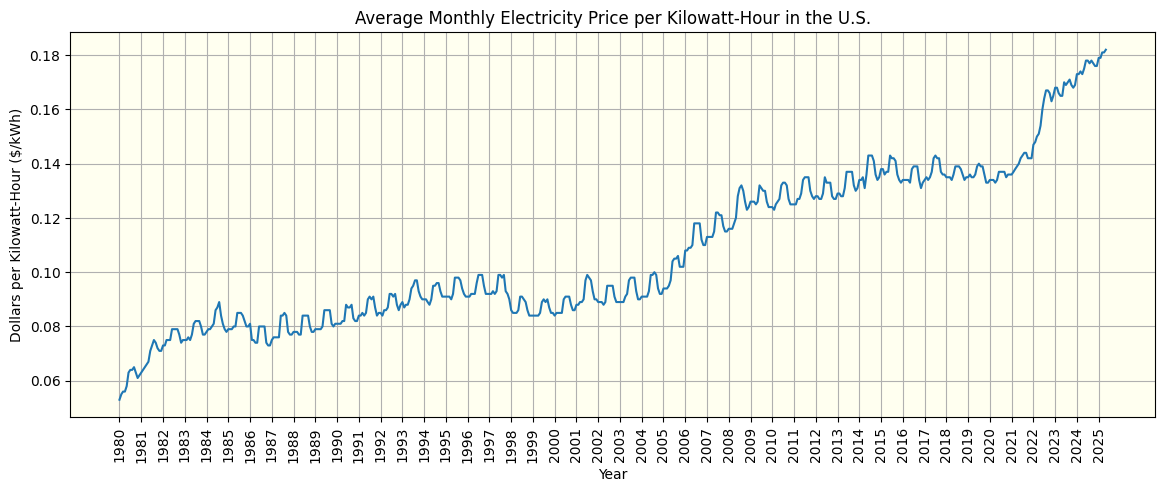

In [1]:
# Load Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.width', 250)

# Load monthly electricity price data
df = pd.read_excel('Average Electricity Price (1980 - 2025).xlsx', sheet_name='python_input')
print(df, '\n')

# Visualize the trend in monthly electricity price
plt.figure(figsize=(14,5))
sns.lineplot(data=df, y='Electricity_Price', x=df['Date'])
plt.xticks(df['Date'][::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel("Year")
plt.ylabel("Dollars per Kilowatt-Hour ($/kWh)")
plt.title("Average Monthly Electricity Price per Kilowatt-Hour in the U.S.")
plt.gca().set_facecolor('ivory')
plt.grid(True)
plt.show()


## Creating Separate Lineplots for Potential External Regressors
Note: Unlike the other external regressors, which provide data from as early as January 1980, the Henry Hub natural gas price is available only from January 1997 through March 2025.

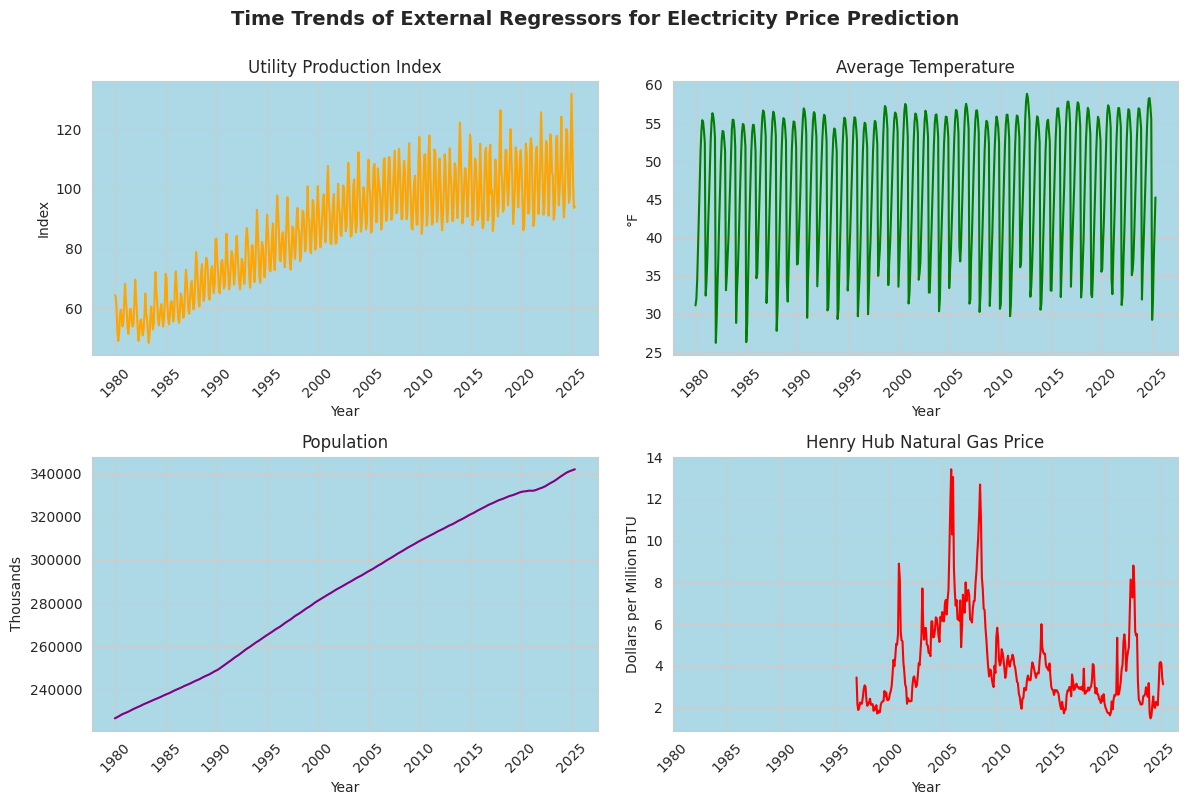

In [ ]:
# List of variables to plot
variables = ['Utility_Production', 'Temperature', 'Population', 'Gas_Price']
titles = ['Utility Production Index', 'Average Temperature', 'Population', 'Henry Hub Natural Gas Price']
ylabels = ['Index', '°F', 'Thousands', 'Dollars per Million BTU']

colors = ['orange', 'green', 'purple', 'red']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

fig.suptitle("Time Trends of External Regressors for Electricity Price Prediction", fontsize=14, y=1.0, fontweight='bold')

for i, (var, color, title, y_label) in enumerate(zip(variables, colors, titles, ylabels)):
    sns.lineplot(ax=axes[i], data=df, x='Date', y=var, color=color)
    axes[i].set_title(title)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(y_label)
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].set_xticks(df['Date'][::60])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)
    axes[i].set_facecolor('lightblue')

plt.tight_layout(w_pad= 2)
plt.show()


## Creating Scatter Plots of Monthly Electricity Price ($/kWh) vs. Potential External Regressors

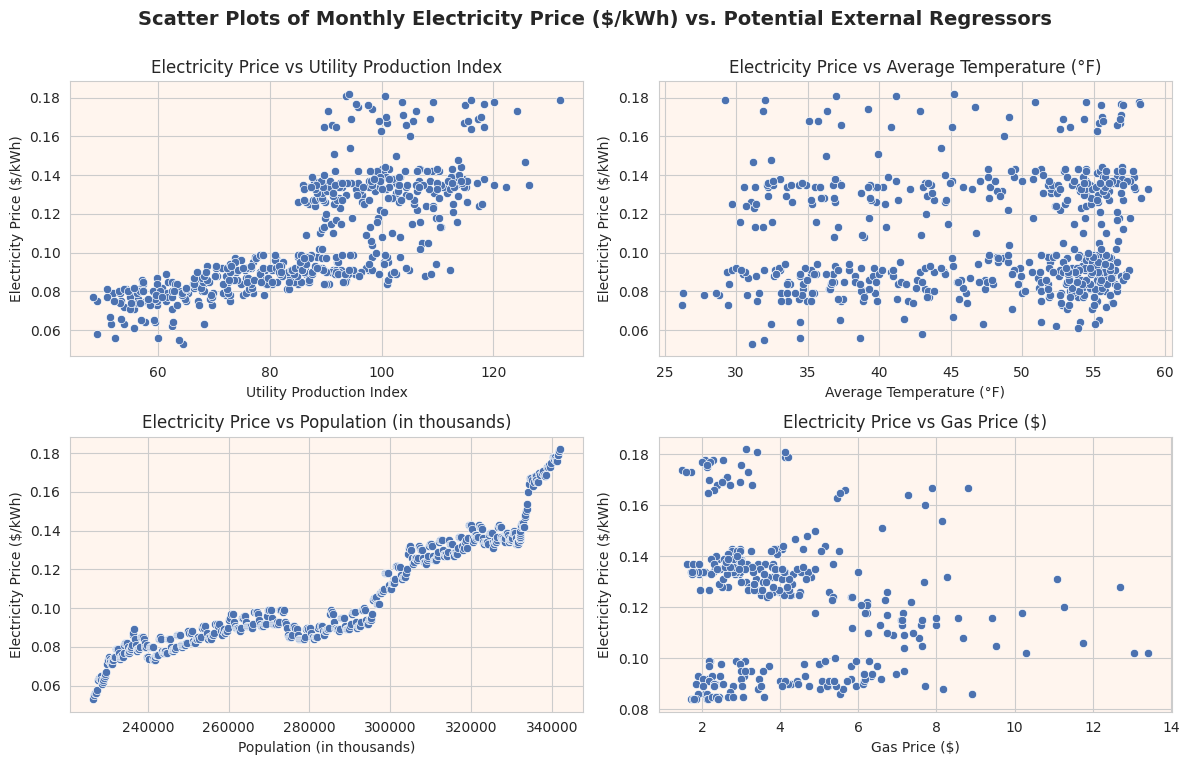

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Scatter Plots of Monthly Electricity Price ($/kWh) vs. Potential External Regressors", fontsize=14, y=0.95, fontweight='bold')

x_vars = ['Utility_Production', 'Temperature', 'Population', 'Gas_Price']
titles = ['Utility Production Index', 'Average Temperature (°F)', 'Population (in thousands)', 'Gas Price ($)']

for ax, x_var, title in zip(axes.flatten(), x_vars, titles):
    sns.scatterplot(data=df, x=x_var, y='Electricity_Price', ax=ax)
    ax.set_title(f'Electricity Price vs {title}')
    ax.set_xlabel(title)
    ax.set_ylabel('Electricity Price ($/kWh)')
    ax.set_facecolor('seashell')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Dual-Axis Time Series Plot of Monthly Electricity Price and Natural Gas Price**

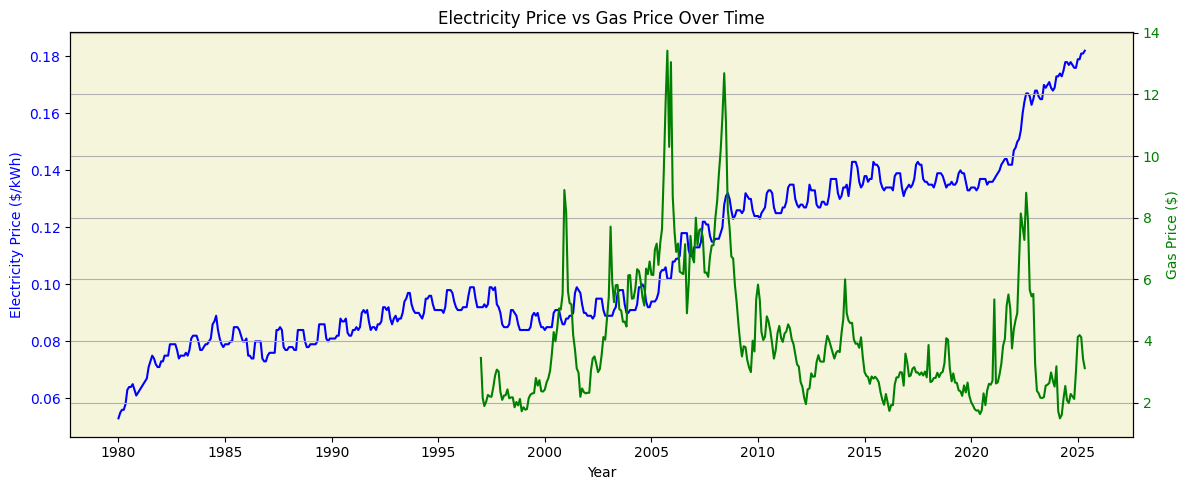

In [2]:
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df['Date'], df['Electricity_Price'], color='blue', label='Electricity Price ($/kWh)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Electricity Price ($/kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_facecolor('beige')

ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Gas_Price'], color='green', label='Gas Price ($)')
ax2.set_ylabel('Gas Price ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Electricity Price vs Gas Price Over Time')
fig.tight_layout()
plt.grid(True)
plt.show()


### **Capturing Natural Gas Price Spikes Using a Dummy Regressor**
The dual-axis line plot above reveals a clear pattern: sudden increases in natural gas prices frequently coincide with jumps in monthly electricity prices. This relationship is expected, given that natural gas has become the dominant source of electricity generation in the U.S., particularly after 2018.
Neverthless, unlike other external regressors—such as utility production index, temperature, and population, which contains full data coverage from January 1980, the Henry Hub natural gas price data is only available from January 1997 onward. This limited temporal coverage posed a challenge for incorporating gas price effects on monthly electricity price. To address this, a binary indicator variable named **spike** was created to represent gas price surge periods. This dummy variable is assigned a value of 1 for a 4-month period if the average natural gas price in that current 4-month window is higher than the average values of the preceding and following 4-month windows plus half the standard deviation above the overall mean gas price. Otherwise, the dummy variable remains 0. This logic was implemented using a sliding window approach with a step size of 4 months, ensuring detection of localized gas price spikes while preventing overlapping flags.

In [3]:
df['spike'] = 0

window = 4
step = 4
mean_price = df['Gas_Price'].mean()
std_price = df['Gas_Price'].std()

threshold = mean_price + 0.5*std_price

for i in range(window, len(df) - 2 * window, step):
    prev_mean = df.loc[i - window:i - 1, 'Gas_Price'].mean()
    curr_mean = df.loc[i:i + window - 1, 'Gas_Price'].mean()
    next_mean = df.loc[i + window:i + 2 * window - 1, 'Gas_Price'].mean()

    if (curr_mean > threshold) and (curr_mean > prev_mean) and (curr_mean > next_mean):
        df.loc[i:i + window - 1, 'spike'] = 1.0
        print(f"\nSpike window: {df.loc[i, 'Date'].date()} to {df.loc[i + window - 1, 'Date'].date()}")
        print(f"Average Gas Price during spike window: {curr_mean:.3f}")

# List of gas price spikes:
print("\nFinal spike-tagged rows:")
print(df[df['spike'] == 1.0][['Date', 'Gas_Price', 'spike']])



Spike window: 2000-09-01 to 2000-12-01
Average Gas Price during spike window: 6.125

Spike window: 2003-01-01 to 2003-04-01
Average Gas Price during spike window: 6.082

Spike window: 2005-09-01 to 2005-12-01
Average Gas Price during spike window: 12.130

Spike window: 2007-01-01 to 2007-04-01
Average Gas Price during spike window: 7.315

Spike window: 2008-05-01 to 2008-08-01
Average Gas Price during spike window: 10.827

Spike window: 2022-05-01 to 2022-08-01
Average Gas Price during spike window: 7.982

Final spike-tagged rows:
          Date  Gas_Price  spike
248 2000-09-01       5.06      1
249 2000-10-01       5.02      1
250 2000-11-01       5.52      1
251 2000-12-01       8.90      1
276 2003-01-01       5.43      1
277 2003-02-01       7.71      1
278 2003-03-01       5.93      1
279 2003-04-01       5.26      1
308 2005-09-01      11.75      1
309 2005-10-01      13.42      1
310 2005-11-01      10.30      1
311 2005-12-01      13.05      1
324 2007-01-01       6.55      1


### Dual-Axis Time Series Plot of Monthly Electricity and Natural Gas Prices With Spike Indicators

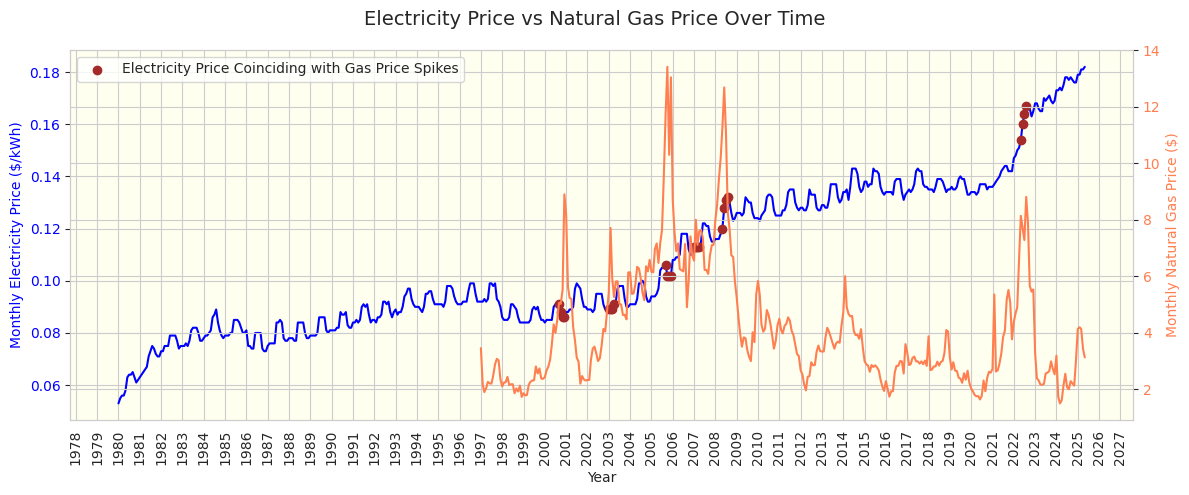

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Electricity_Price on the left y-axis
ax1.plot(df['Date'], df['Electricity_Price'], color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly Electricity Price ($/kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_facecolor('ivory')
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=90)
# Overlay spike points
spike_df = df[df['spike'] == 1.0]
ax1.scatter(spike_df['Date'], spike_df['Electricity_Price'], color='brown', label='Electricity Price Coinciding with Gas Price Spikes', zorder=5)

# Plot Gas_Price on the right y-axis
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Gas_Price'], color='coral', label='Natural Gas Price ($)')
ax2.set_ylabel('Monthly Natural Gas Price ($)', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

fig.suptitle('Electricity Price vs Natural Gas Price Over Time', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
ax1.legend(loc='upper left')
plt.grid(True)
plt.show()


**As illustarted in the dual-axis plot above**, there is a direct relationship between natural gas price spikes and subsequent increases in electricity prices. Notably, during the four-month period from **May 2022 to August 2022**, natural gas prices experienced a sharp surge. Following this spike, a significant rise in electricity prices was observed, indicating a potential lagged effect of natural gas cost changes on electricity pricing. Similar patterns appear during other periods as well, where electricity prices responded to natural gas price volatility. This relationship is consistent with expectations, given that natural gas has recently become the primary source of electricity generation in the United States.


### **Performing Additive Seasonal Decomposition of the Electricity Price Time Series**

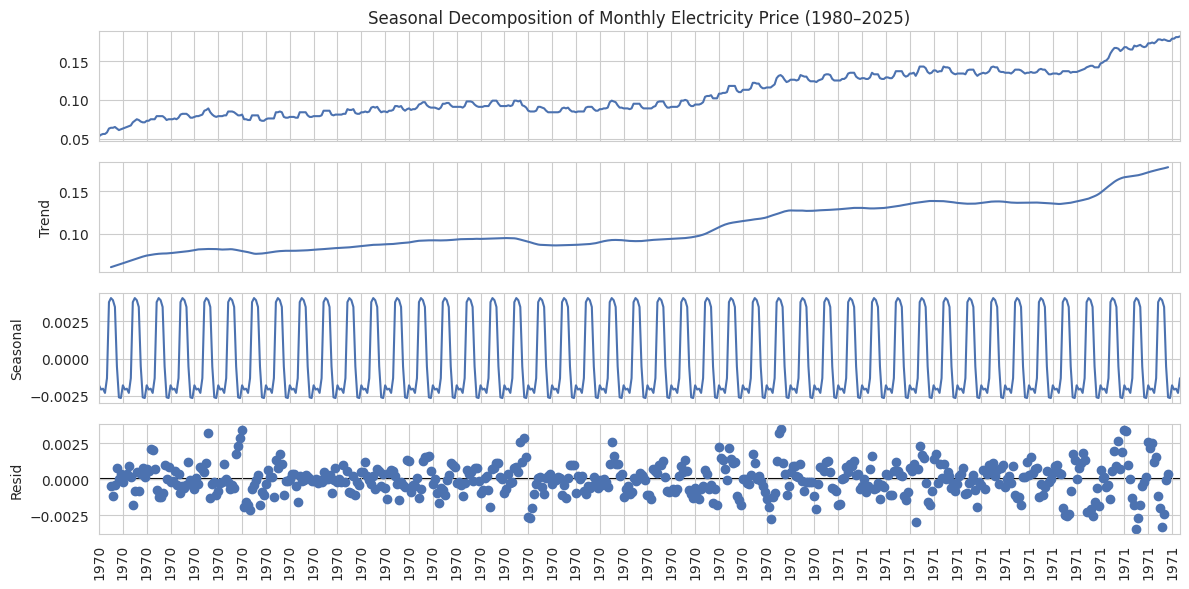

In [ ]:
# Plotting the decomposed plot:
result = seasonal_decompose(df['Electricity_Price'], model='additive', period=12)
fig = result.plot()
fig.set_size_inches(12, 6)
fig.axes[0].set_title("Seasonal Decomposition of Monthly Electricity Price (1980–2025)")  # Clear the first subplot's title
plt.xticks(df.index[::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


#### Key Findings from Seasonal Decomposition Components for SARIMA Models

- **Seasonality**: The seasonal component remains constant over time, implying that an **additive seasonal model** is appropriate.

- **Trend**: There is a steady upward trend, suggesting that the time series is non-stationary—an important consideration when developing a SARIMA model.

- **Differencing before fitting a SARIMA model**:
  - Apply **first-order non-seasonal differencing** (d = 1) to eliminate the linear trend.
  - Apply **seasonal differencing** (D = 1) to remove seasonal effects.

- **Residuals**: The residual component exhibits no clear patterns or structures, indicating that the residuals are **white noise**.

- **Variance Stability**: There are no signs of heteroskedasticity in the time series.



---
---
## **TRAIN-TEST SPLIT FOR MODEL DEVELOPMENT & EVALUATION**

To develop and evaluate the prediction performance of the alternative models, the dataset was divided into two subsets:

- **Training Sample (95%)**: Includes all data points prior to January 2023, used to train the models.
- **Test Sample (5%)**: Contains data from January 2023 onward, reserved for testing and evaluating the models' prediction accuracy.


Total Length of Sample: 545
Length of Training Sample: 516
Length of Test Sample: 29

Training Sample:
            ds      y  Utility_Production  Population  Temperature  Gas_Price  spike
0   1980-01-01  0.053             64.4041      226554        31.12        NaN      0
1   1980-02-01  0.055             63.8043      226753        31.99        NaN      0
2   1980-03-01  0.056             59.9710      226955        34.44        NaN      0
3   1980-04-01  0.056             52.3178      227156        38.69        NaN      0
4   1980-05-01  0.058             49.0551      227387        43.00        NaN      0
..         ...    ...                 ...         ...          ...        ...    ...
511 2022-08-01  0.167            114.7776      334652        55.41       8.81      1
512 2022-09-01  0.167            100.9932      334912        56.81       7.88      0
513 2022-10-01  0.166             91.0842      335155        56.65       5.66      0
514 2022-11-01  0.163             99.8793      

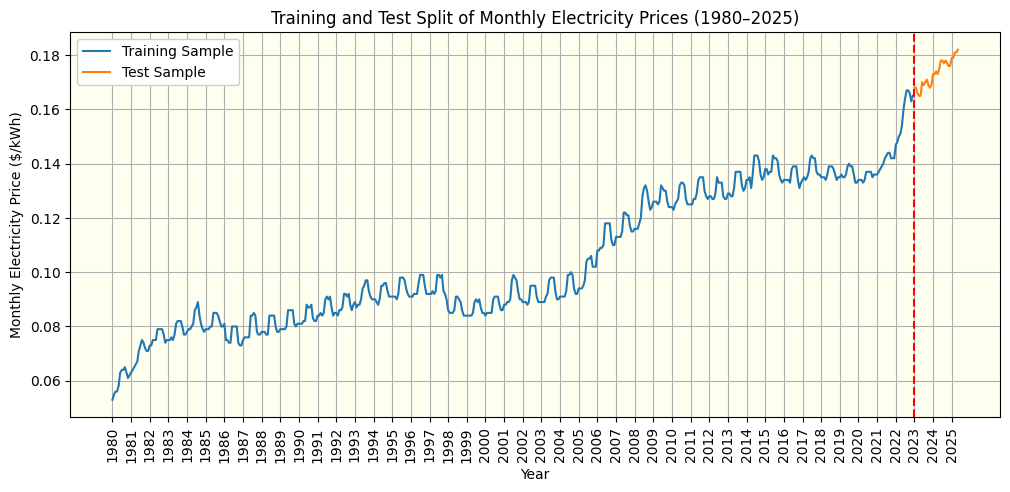

In [4]:
# Splitting the time series into training and test subsampels:
df = df.rename(columns={'Date': 'ds', 'Electricity_Price': 'y'})
df_train = df[df['ds'] < '2023-01-01'] # Contains 95% of total observations
df_test = df[df['ds'] >= '2023-01-01'] # Contains 5% of total observations

print(f"Total Length of Sample: {len(df)}")
print(f"Length of Training Sample: {len(df_train)}")
print(f"Length of Test Sample: {len(df_test)}")
print()

print("Training Sample:")
print(df_train)
print()

print("Test Sample (first-5):")
print(df_test.head(5))

print("Test Sample (end-5):")
print(df_test.tail(5), '\n\n')

# Plotting Monthly Electricity Price Over Time for Training and Test Subsamples:
plt.figure(figsize=(12, 5))
sns.lineplot(df_train, x=df_train['ds'], y='y', label="Training Sample")
sns.lineplot(df_test, x=df_test['ds'], y='y', label="Test Sample")
plt.axvline(x=pd.to_datetime('2023-01'), color='red', linestyle='--', linewidth=1.5)
plt.title("Training and Test Split of Monthly Electricity Prices (1980–2025)")
plt.xlabel("Year")
plt.ylabel("Monthly Electricity Price ($/kWh)")
plt.gca().set_facecolor('ivory')
plt.xticks(df['ds'][::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.legend(framealpha=1)
plt.show()


---
---
# **TIME SERIES MODEL DEVELOPMENT AND COMPARISON**

This section presents the development and evaluation of multiple time series forecasting models to predict monthly electricity prices. The models implemented include:

**1. Facebook Prophet**  
**2. SARIMA (Seasonal Autoregressive Integrated Moving Average)**  
**3. Holt-Winters Triple Exponential Smoothing**

Each model was developed on training data and assessed on test data using common prediction metrics to compare their performance. The goal was to identify the most accurate and robust model for capturing both trend and seasonal patterns in electricity prices.


## **1. Fitting the Facebook Prophet Model**

The **Facebook Prophet** model is a powerful time series forecasting model developed by Facebook’s Core Data Science team. It offers several advantages over traditional forecasting methods, including the ability to:
- Incorporate **holiday effects**
- Model **multiple built-in and customized seasonalities** (e.g., yearly, weekly, or custom)
- Detect and model **changepoints** in time series trends

Like SARIMA model, Prophet also supports **external regressors**, but with a key difference: Prophet applies **ridge regularization (L2 penalty)** to its regressors by default. This helps reduce overfitting and mitigate the impact of multicollinearity among predictors.

---

**Modeling Strategy**

To evaluate the impact of external variables on electricity price prediction, two Prophet models were developed and compared:

1. **Model with external regressors**, including:
   - `Utility Production Index`
   - `Population`
   - `Average Monthly Temperature`
   - `spike` (a dummy variable indicating natural gas price spikes)

2. **Model without external regressors**


Since Prophet’s prediction performance can highly be influenced by changepoint-related hyperparameters, a **custom grid search** was implemented to tune the following:

- `changepoint_prior_scale`  
- `n_changepoints`  
- `changepoint_range`

Each combination of hyperparameters was evaluated using **time series cross-validation** from the Facebook Prophet diagnostics module, with performance assessed based on the **average Root Mean Squared Error (RMSE)**.

---
---

### **1.1. Fitting the Facebook Prophet Model with External Regressors**

#### **Key Implementation Steps**

- Define a parameter grid for changepoint hyperparameter tuning
- Add external regressors to the model
- Fit the model using the training dataset
- Perform cross-validation using prophet.diagnostics.cross_validation()
- Select the best model configuration based on validation RMSE



In [ ]:
import logging
from io import StringIO
from contextlib import redirect_stdout, redirect_stderr
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)

silent = StringIO()

# Suppress INFO and DEBUG messages globally
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Defining Facebook Prophet hyperparameter grid with various value options
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.2, 0.3],
    'n_changepoints': [10, 30, 50],
    'changepoint_range': [0.1, 0.25, 0.5, 0.75, 1]
}

FB_params = list(ParameterGrid(param_grid))
results = []

with redirect_stdout(silent), redirect_stderr(silent):
    for params in FB_params:
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            changepoint_range=params['changepoint_range']
        )
        model.add_regressor('Utility_Production')
        model.add_regressor('Population')
        model.add_regressor('spike')

        model.fit(df_train[['ds', 'y', 'Utility_Production', 'Population', 'spike']])
        df_cv = cross_validation(
            model,
            initial='1095 days',
            period='365 days',
            horizon='730 days'
        )
        df_perf = performance_metrics(df_cv)
        avg_rmse = df_perf['rmse'].mean()
        results.append({**params, 'avg_rmse': avg_rmse})

# ✅ Only the final result will be printed
best_params = min(results, key=lambda x: x['avg_rmse'])
print("Best hyperparameters based on cross-validation RMSE:", best_params)


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Best hyperparameters based on cross-validation RMSE: {'changepoint_prior_scale': 0.2, 'changepoint_range': 1, 'n_changepoints': 10, 'avg_rmse': np.float64(0.0055595900101697016)}


#### **Fitting the Facebook Prophet Model with Optimal Changepoint-Related Parameters**
- 'changepoint_prior_scale': 0.2
- 'changepoint_range': 1.0
- 'n_changepoints': 10

In [23]:
FC_Prophet_with_regr = Prophet(seasonality_mode='additive', changepoint_prior_scale=0.2, changepoint_range=1, n_changepoints= 10)
FC_Prophet_with_regr.add_regressor('Utility_Production')
FC_Prophet_with_regr.add_regressor('Population')
FC_Prophet_with_regr.add_regressor('spike')

FC_Prophet_with_regr.fit(df_train[['ds', 'y', 'Utility_Production', 'Population', 'spike']])

# Checking what seasonalities were included in the model after fitting, where yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto':
FC_Prophet_with_regr.seasonalities
# To show the model parameters: FC_Prophet_with_regr.params


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12bhhy5u/n8vp7rot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12bhhy5u/ja_5x2kb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41348', 'data', 'file=/tmp/tmp12bhhy5u/n8vp7rot.json', 'init=/tmp/tmp12bhhy5u/ja_5x2kb.json', 'output', 'file=/tmp/tmp12bhhy5u/prophet_modeltag0mwfw/prophet_model-20250720174748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

#### **Facebook Prophet Model Prediction & Visualization for the Training & Test Sets**

The Facebook Prophet model above was then used to predict monthly electricity price over two separate time periods:

- **Training period**: 516 future observations spanning from **January 1980 to December 2022**.

- **Test period**: 29 observations from **January 2023 to March 2025**, used to evaluate the model's predictive accuracy on unseen data.


The predicted values for the aformentioned periods were then visualized alongside the correspodning actual samples to assess the model’s performance, especially for the test period.

**Note:** The fitted model is capable of forecasting monthly electricity prices beyond March 2025, given that future values for the external regressors (e.g., utility production, population, and gas price spikes) are available. However, since these future regressor values are currently unavailable, the prediction was limited to the training and test periods only.

            ds      yhat  yhat_lower  yhat_upper
0   1980-01-01  0.056640    0.052599    0.060780
1   1980-02-01  0.057599    0.053752    0.061646
2   1980-03-01  0.058543    0.054816    0.062415
3   1980-04-01  0.059405    0.055317    0.063231
4   1980-05-01  0.060698    0.056790    0.064623
..         ...       ...         ...         ...
540 2025-01-01  0.176258    0.171631    0.180959
541 2025-02-01  0.175994    0.171064    0.181038
542 2025-03-01  0.175111    0.169943    0.179949
543 2025-04-01  0.175779    0.170697    0.180909
544 2025-05-01  0.177411    0.172319    0.182307

[545 rows x 4 columns] 



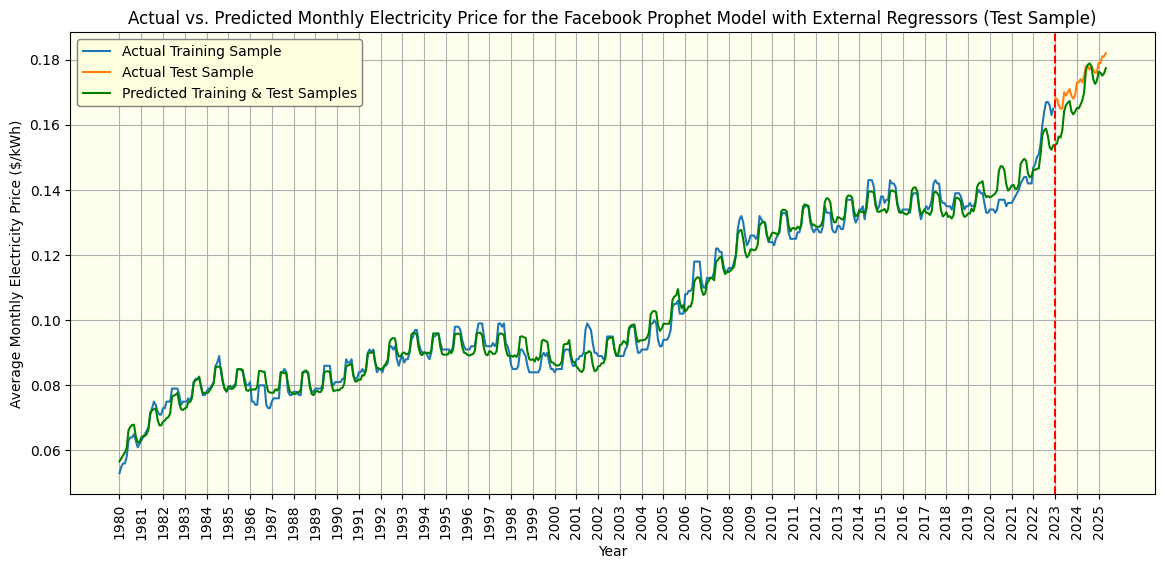

In [24]:
prediction_dataframe = FC_Prophet_with_regr.make_future_dataframe(periods=len(df_test), freq='MS')
# Adding date ('ds') to the prediction_dataframe dataframe
prediction_dataframe = prediction_dataframe.merge(df, on='ds', how='left')

predicted_FCB_Wreg = FC_Prophet_with_regr.predict(prediction_dataframe)
print(predicted_FCB_Wreg[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], '\n')

# Plotting Actual Monthly Electricity Price for Training and Test Subsamples:
plt.figure(figsize=(14, 6))
sns.lineplot(df_train, x='ds', y='y', label="Actual Training Sample")
sns.lineplot(df_test, x='ds', y='y', label="Actual Test Sample")

# Plotting Predicted Monthly Electricity Price for Training and Test Subsamples:
sns.lineplot(predicted_FCB_Wreg, x='ds', y='yhat', color='green', label="Predicted Training & Test Samples")

# Add vertical line at 2023-01:
plt.axvline(x=pd.to_datetime('2023-01'), color='red', linestyle='--', linewidth=1.5)

plt.title("Actual vs. Predicted Monthly Electricity Price for the Facebook Prophet Model with External Regressors (Test Sample)")
plt.xlabel("Year")
plt.xticks(predicted_FCB_Wreg['ds'][::12], rotation=90)
plt.ylabel("Average Monthly Electricity Price ($/kWh)")
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('ivory')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.show()


In [ ]:
# Visualizing the Predicted Values with an Interactive Plotly Chart
plot_plotly(FC_Prophet_with_regr, predicted_FCB_Wreg)


#### **Performance Metrics (RMSE and MAE) for the Prophet Model With External Regressors on the Test Data**

In [25]:
# Step1: Calculating test-sample SSE:
predicted_test_FB_Wreg = predicted_FCB_Wreg[predicted_FCB_Wreg['ds'].isin(df_test['ds'])]['yhat']
mse_test_FB_Wreg = mean_squared_error(df_test['y'], predicted_test_FB_Wreg)
# Step 2: Calculating RMSE and MAE:
rmse_test_FB_Wreg = round(np.sqrt(mse_test_FB_Wreg), 5)
mae_test_FB_Wreg = round(mean_absolute_error(df_test['y'], predicted_test_FB_Wreg), 5)
print(f"RMSE of the Facebook Prophet Model with External Regressors on the Test Sample: {rmse_test_FB_Wreg}")
print(f"MAE of the Facebook Prophet Model with External Regressors on the Test Sample: {mae_test_FB_Wreg}")


RMSE of the Facebook Prophet Model with External Regressors on the Test Sample: 0.00621
MAE of the Facebook Prophet Model with External Regressors on the Test Sample: 0.00523


---
---
### **1.2. Fitting the Facebook Prophet Model without External Regressors**
#### **Key Implementation Steps**
- Define a parameter grid for changepoint hyperparameter tuning
- Fit the model using the training dataset
- Perform cross-validation using prophet.diagnostics.cross_validation()
- Select the best model configuration based on validation RMSE

In [ ]:
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
silent = StringIO()

# Define Prophet hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.2, 0.3],
    'n_changepoints': [10, 30, 50],
    'changepoint_range': [0.1, 0.25, 0.5, 0.75, 1]
}

FB_params = list(ParameterGrid(param_grid))

results = []

# Loop through each combination
with redirect_stderr(silent):
    for params in FB_params:
        model_Nreg = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            n_changepoints=params['n_changepoints'],
            changepoint_range=params['changepoint_range']
        )
        model_Nreg.fit(df_train[['ds', 'y']])

        # Cross-validation
        df_cv = cross_validation(
            model_Nreg,
            initial='1825 days',
            period='365 days',
            horizon='730 days'
        )

        # Calculate RMSE
        df_perf = performance_metrics(df_cv)
        avg_rmse = df_perf['rmse'].mean()

        # Save result
        results.append({**params, 'avg_rmse': avg_rmse})

# Print best set
best_params = min(results, key=lambda x: x['avg_rmse'])
print("Optimal changepoint parameters from time series cross-validation:", best_params)


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Optimal changepoint parameters from time series cross-validation: {'changepoint_prior_scale': 0.2, 'changepoint_range': 1, 'n_changepoints': 50, 'avg_rmse': np.float64(0.005323241119350868)}


#### **Fitting the Facebook Prophet Model (without Regressors) with Optimal Changepoint-Related Parameters**
- 'changepoint_prior_scale': 0.1
- 'changepoint_range': 0.9
- 'n_changepoints': 50

In [27]:
FC_Prophet_no_regr = Prophet(seasonality_mode='additive', changepoint_prior_scale=0.1, changepoint_range=0.9, n_changepoints=50)
FC_Prophet_no_regr.fit(df_train)

# To check which seasonalities were actually included in the model after fitting, where yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto':
FC_Prophet_no_regr.seasonalities

# To show the model parameters: FC_Prophet_with_regr.params


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12bhhy5u/vyebfd4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp12bhhy5u/xfa6kljb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20178', 'data', 'file=/tmp/tmp12bhhy5u/vyebfd4z.json', 'init=/tmp/tmp12bhhy5u/xfa6kljb.json', 'output', 'file=/tmp/tmp12bhhy5u/prophet_modeljl403smd/prophet_model-20250720174839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

#### **Facebook Prophet Model (without Regressors) Prediction & Visualization for the Training & Test Sets**
- **Training period**: 516 future observations spanning from **January 1980 to December 2022**.

- **Test period**: 29 observations from **January 2023 to March 2025**, used to evaluate the model's predictive accuracy on unseen data.

**Note:** Since the Facebook Prophet model above did not incorporate external regressors, it is capable of forecasting monthly electricity prices beyond March 2025. However, the prediction was limited to the training and test periods to enable a more consistent and meaningful comparison with the counterpart model that includes external regressors.

            ds      yhat  yhat_lower  yhat_upper
0   1980-01-01  0.055439    0.052244    0.058937
1   1980-02-01  0.055924    0.052490    0.059206
2   1980-03-01  0.056562    0.053157    0.059757
3   1980-04-01  0.057346    0.054038    0.060774
4   1980-05-01  0.059024    0.055506    0.062321
..         ...       ...         ...         ...
540 2025-01-01  0.160905    0.156763    0.165134
541 2025-02-01  0.161006    0.156538    0.165242
542 2025-03-01  0.161008    0.156380    0.165336
543 2025-04-01  0.161313    0.156437    0.166023
544 2025-05-01  0.162751    0.158296    0.167296

[545 rows x 4 columns]


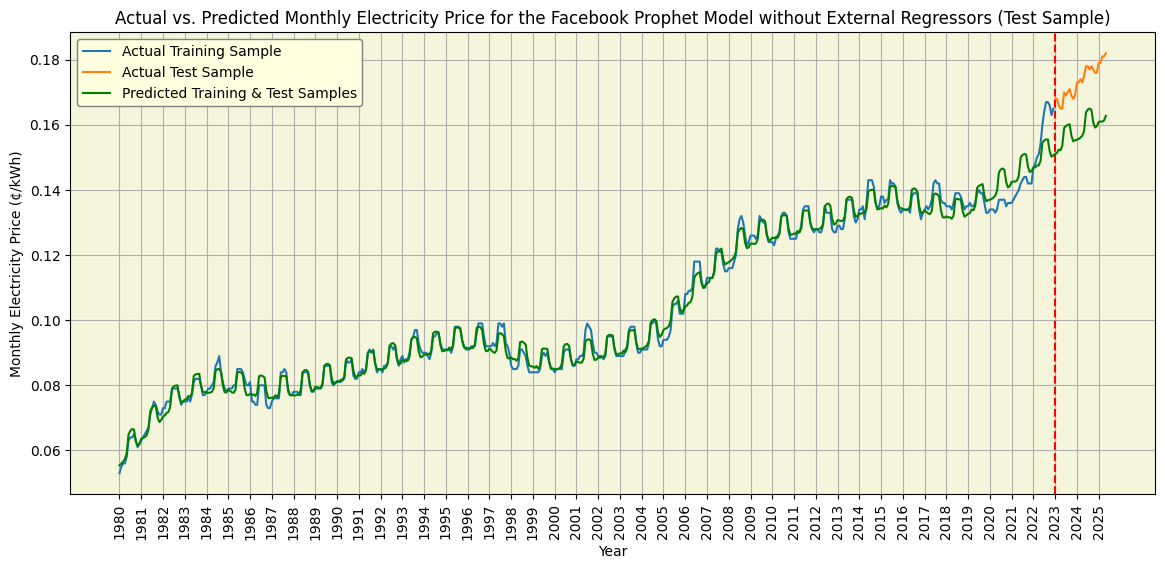

In [28]:
# Creating dataframe for making predictions for training and test subsamples:
prediction_dataframe2 = FC_Prophet_no_regr.make_future_dataframe(periods=len(df_test), freq='MS')

# Adding date ('ds') to the prediction_dataframe dataframe
prediction_dataframe2 = prediction_dataframe2.merge(df, on='ds', how='left')

predicted_FCB_no_reg = FC_Prophet_no_regr.predict(prediction_dataframe2)
print(predicted_FCB_no_reg[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

predicted_FCB_no_reg.head()

# Plotting Monthly Sales Over Time for Training, Test, and Forecast Samples:
plt.figure(figsize=(14, 6))
sns.lineplot(df_train, x='ds', y='y', label="Actual Training Sample")
sns.lineplot(df_test, x='ds', y='y', label="Actual Test Sample")
sns.lineplot(predicted_FCB_no_reg, x=predicted_FCB_no_reg['ds'], y='yhat', color='green', label="Predicted Training & Test Samples")

# Add vertical line at 2023-01:
plt.axvline(x=pd.to_datetime('2023-01'), color='red', linestyle='--', linewidth=1.5)

plt.title("Actual vs. Predicted Monthly Electricity Price for the Facebook Prophet Model without External Regressors (Test Sample)")
plt.xlabel("Year")
plt.xticks(predicted_FCB_no_reg['ds'][::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('beige')
plt.ylabel("Monthly Electricity Price (¢/kWh)")
plt.grid(True)
plt.show()


In [ ]:
# Visualizing the Predicted Values with an Interactive Plotly Chart
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(FC_Prophet_no_regr, predicted_FCB_no_reg)


#### **Performance Metrics (RMSE and MAE) for the Prophet Model Without External Regressors on the Test Data**

In [29]:
# Step1: Calculating test-sample SSE:
sse_no_reg = np.square(predicted_FCB_no_reg[predicted_FCB_no_reg['ds'].isin(df_test['ds'])]['yhat']-df_test['y']).sum()

# Step 2: Calculating RMSE and MAE:
predicted_test_FB_Nreg = predicted_FCB_no_reg[predicted_FCB_no_reg['ds'].isin(df_test['ds'])]['yhat']
mse_test_FB_Nreg = mean_squared_error(df_test['y'], predicted_test_FB_Nreg)
rmse_test_FB_Nreg = round(np.sqrt(mse_test_FB_Nreg), 5)
mae_test_FB_Nreg = round(mean_absolute_error(df_test['y'], predicted_test_FB_Nreg), 5)

print(f"RMSE of the Facebook Prophet Model without External Regressors on the Test Sample: {rmse_test_FB_Nreg}")
print(f"MAE of the Facebook Prophet Model without External Regressors on the Test Sample: {mae_test_FB_Nreg}")


RMSE of the Facebook Prophet Model without External Regressors on the Test Sample: 0.0153
MAE of the Facebook Prophet Model without External Regressors on the Test Sample: 0.015


### **Plotting the RMSE and MAE Metrics for the Facebook Prophet Model with and without External Regressors**

                                        RMSE      MAE
Facebook Prophet with Regressors     0.00621  0.00523
Facebook Prophet without Regressors  0.01530  0.01500 



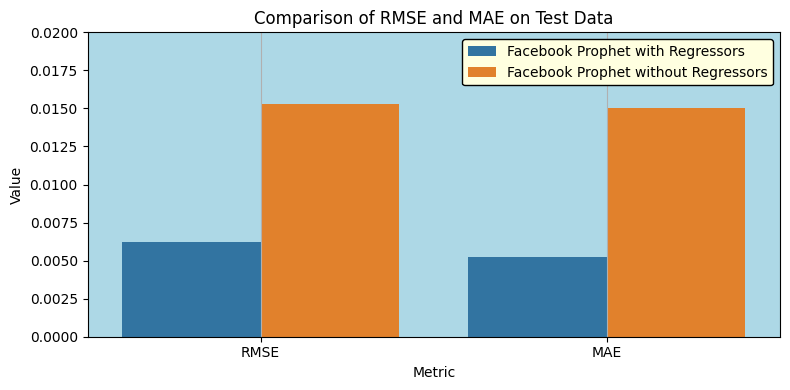

In [30]:
data = pd.DataFrame({'Metric': ['RMSE', 'MAE', 'RMSE', 'MAE'], 'Value': [rmse_test_FB_Wreg, mae_test_FB_Wreg, rmse_test_FB_Nreg, mae_test_FB_Nreg], 'Model': ['Facebook Prophet with Regressors', 'Facebook Prophet with Regressors', 'Facebook Prophet without Regressors', 'Facebook Prophet without Regressors']
})
print(pd.DataFrame({'RMSE': [rmse_test_FB_Wreg, rmse_test_FB_Nreg], 'MAE': [mae_test_FB_Wreg,  mae_test_FB_Nreg]}, index= ['Facebook Prophet with Regressors', 'Facebook Prophet without Regressors']), '\n')

plt.figure(figsize=(8, 4))
sns.barplot(data=data, x='Metric', y='Value', hue='Model')
plt.title("Comparison of RMSE and MAE on Test Data")
plt.xlabel("Metric")
plt.ylim(0, 0.02)
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('lightblue')
plt.grid(axis='y')
plt.tight_layout()
plt.grid()
plt.show()


#### **Inference from the Barplot of RMSE and MAE**
The bar plot comparison of RMSE and MAE on the test dataset clearly shows that the Facebook Prophet model with external regressors substantially outperformed the model without them. Including monthly utility production index, and population, and gas price spike indicator as external features improved prediction accuracy by approximately 45% in RMSE and 47% in MAE, highlighting the value of incorporating relevant contextual variables.



---
### **Actual vs. Predicted Electricity Prices for the Facebook Prophet Model with and without External Regressors**

This superiority of the FB with regressors is also visually evident in the line plot below, where the blue curve (FB with external regressors) follows more closely the actual electricity price (green dashed line) than the orange curve (FB without external regressors).

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test['ds'], y= df_test['y'], mode='lines', name='Actual Value', line=dict(color='green', dash='dash')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=predicted_test_FB_Wreg, mode='lines', name='FB-P with Regressors', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=predicted_test_FB_Nreg, mode='lines', name='FB-P without Regressors', line=dict(color='coral')))

# Updating layout
fig.update_layout(
    title='Actual vs. Predicted Monthly Electricity Price over Test Period (January 2023 – May 2025)',
    xaxis_title='Year',
    yaxis_title='Monthly Electricity Price ($/kWh)',
    title_font=dict(size=18),
    font=dict(family='Arial', size=14),
    hovermode='x unified',
    width=1100,
    height=500
)

fig.show()


## **2. Fitting the SARIMA Model**

The **Seasonal Autoregressive Integrated Moving Average (SARIMA)** model is an advanced extension of the ARIMA model. It accounts for both non-seasonal and seasonal components of time series data, making it suitable for capturing complex temporal patterns such as trends and periodic fluctuations. SARIMA is widely used in domains such as economics, energy, and meteorology to forecast time-dependent phenomena.

In this project, the **`auto_arima()`** function from the `pmdarima` library was used to automatically identify the optimal combination of model parameters `(p, d, q, P, D, Q)` based on information-based performance criteria, such as **AIC** and **BIC**. The function internally handles differencing and seasonal component selection, streamlining the model selection process.

---

### **2.1. Fitting the SARIMA Model with External Regressors**
#### **Important tips when using external regressors in the SARIMA model**

- **(A) Manual Scaling of Regressors**  
  Unlike the Facebook Prophet model, the SARIMA does not include any built-in mechanism for scaling external regressors. Therefore, scaling must be performed manually. In this project, `StandardScaler()` from the `sklearn.preprocessing` module was used to standardize the regressors before model fitting.

- **(B) Handling Multicollinearity**  
  In contrast to the Facebook Prophet model, the SARIMA model does not include a regularization term to address multicollinearity among external regressors. If multicollinearity is present, one solution is to remove the regressor that has a weaker impact on the target variable.  
  In this project, a strong correlation was found between the **utility production index** and **population**. Between these two inter-correlated variables, **population** was found to have a statistically significant effect on monthly electricity prices (p-value < 0.05). Therefore, it was retained in the model.

- **(C) Variable Selection**  
  A **backward stepwise selection** approach was used to iteratively include only statistically significant external regressors. Selection was guided by **AIC/BIC** values and **Wald statistics**, using a 5% significance threshold.

---


#### **Scaling External Regressors before Fitting the SARIMA Model**

In [8]:
# Scaling the exogenous variables
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train[['Utility_Production', 'Population', 'spike']])
df_train_scaled = pd.DataFrame(df_train_scaled, columns=['Utility_Production', 'Population', 'spike'], index=df_train.index)
# Transform the test set
df_test_scaled = scaler.transform(df_test[['Utility_Production', 'Population', 'spike']])
df_test_scaled = pd.DataFrame(df_test_scaled, columns=['Utility_Production','Population', 'spike'], index=df_test.index)


#### **Finding Optimal SARIMA Model Order (p, d, q)(P, D, Q)[12]**
**Note:** The `auto_arima()` function cannot be executed directly on Google Colab. This step was run in **Jupyter Notebook**.


In [ ]:
# Since the data exhibits both trend and seasonality, d and D are both set to 1 in the auto_arima() model below.
from pmdarima import auto_arima
model = auto_arima(df_train['y'], X=df_train_scaled[['Population']], seasonal=True, m=12, d=1, D=1, max_Q=1, trace=True, stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-5343.142, Time=1.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-5181.794, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-5288.385, Time=2.47 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-5349.590, Time=1.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-5181.846, Time=0.37 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-5343.168, Time=0.93 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-5288.062, Time=0.86 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-5350.917, Time=0.78 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-5344.208, Time=0.87 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-5287.660, Time=0.90 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-5349.975, Time=0.73 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-5348.787, Time=0.94 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=-5349.209, Time=1.10 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 13.338 se

The `auto_arima()` function selected **ARIMA(0,1,0)(0,1,1)[12]**, with **monthly population** as the sole external regressor, as the optimal model based on the AIC criterion.


In [33]:
# Fitting the best-fit SARIMA model:
sarimax_best_model= SARIMAX(df_train['y'], order=(0, 1, 0), seasonal_order=(0, 1, 1, 12), exog= df_train_scaled[['Population']])
fit = sarimax_best_model.fit()
print(fit.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  516
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                2678.459
Date:                              Sun, 20 Jul 2025   AIC                          -5350.917
Time:                                      17:49:28   BIC                          -5338.256
Sample:                                           0   HQIC                         -5345.950
                                              - 516                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population     0.1170      0.047      2.476      0.013       0.024       0.210
ma.S.L12      -0.63

#### **Diagnostic Plots for the SARIMAX Model**
This section generates diagnostic plots after fitting the SARIMAX model with the selected optimal parameters. These plots help assess key assumptions, such as the independence of residuals over time and their normality.

<Figure size 1500x1500 with 0 Axes>

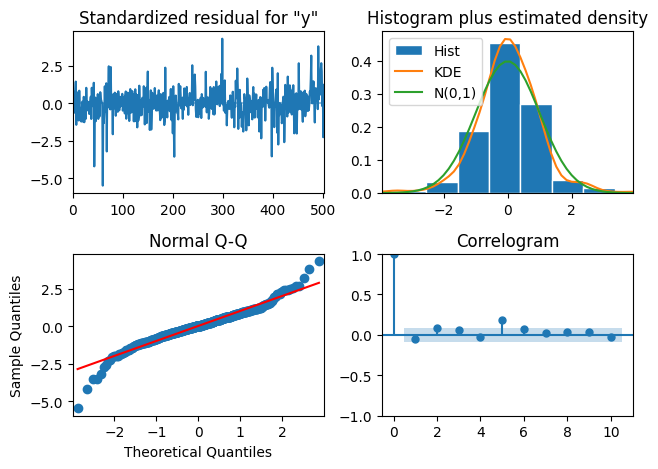

In [11]:
# Create the diagnostic plots after fitting the SARIMAX model with the optimal paramters:
plt.figure(figsize=(15,15))
fit.plot_diagnostics()
plt.tight_layout()
plt.show()


##### **Key Insights from the Diagnostic Plots**

- **Standardized Residuals Plot**  
  The residuals fluctuated around zero, indicating that they resemble white noise.

- **Histogram + KDE Plot**  
  The residuals approximately followed a normal distribution, as evidenced by the overlap between the histogram, KDE, and the standard normal curve.

- **Normal Q-Q Plot**  
  Most data points lay close to the reference line, except for deviations at the tails. This suggests that the residuals are approximately normally distributed.

- **Correlogram (ACF of Residuals)**  
  Nearly all autocorrelation values fell within the 95% confidence bounds (shaded blue area), indicating little to no autocorrelation in the residuals.
  This finding was further supported by the **Ljung-Box test** results provided in the SARIMA model output, which did not indicate statistically significant autocorrelation.
  

---
---

#### **SARIMA Model Prediction & Visualization for the Test Data Sample**
Similar to the Facebook Prophet model, a total of 29 observations spanning from **January 2023 to March 2025**, was used to evaluate the model's predictive accuracy on unseen data.
The predicted values were then visualized alongside the actual training and test samples to assess the model’s performance and long-term forecasting behavior.

First 5 Rows of Predicted Values for the Test Data Set:
516    0.167515
517    0.168701
518    0.169833
519    0.170536
520    0.172710
Name: predicted_mean, dtype: float64

Last 5 Rows of Predicted Values for the Test Data Set:
540    0.195251
541    0.196181
542    0.197051
543    0.197498
544    0.199430
Name: predicted_mean, dtype: float64



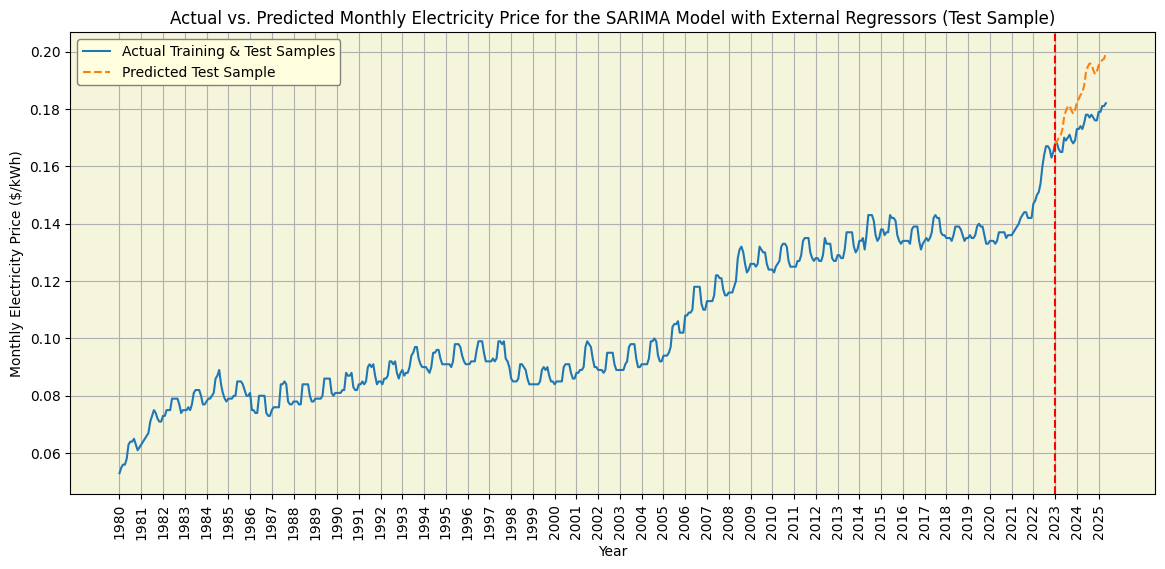

In [34]:
# Predicting the test sample:
predicted_test_sarima_wregr = fit.predict(start=len(df_train), end=len(df)-1, exog=df_test_scaled[['Population']])

print(f"First 5 Rows of Predicted Values for the Test Data Set:")
print(predicted_test_sarima_wregr.head())
print()
print(f"Last 5 Rows of Predicted Values for the Test Data Set:")
print(predicted_test_sarima_wregr.tail())
print()

# Plot for observed vs fitted values for the test sample:
plt.figure(figsize=(14, 6))
sns.lineplot(data= df, x= df['ds'], y=df['y'], label="Actual Training & Test Samples")
sns.lineplot(data= df_test, x= df_test['ds'], y= predicted_test_sarima_wregr.values, linestyle="--", label="Predicted Test Sample")
plt.axvline(x=pd.to_datetime('2023-01'), color='red', linestyle='--', linewidth=1.5)

plt.title("Actual vs. Predicted Monthly Electricity Price for the SARIMA Model with External Regressors (Test Sample)")
plt.xlabel("Year")
plt.xticks(df['ds'][::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylabel("Monthly Electricity Price ($/kWh)")
plt.grid(True)
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('beige')
plt.show()


#### **Calculating RMSE and MAE of the SARIMA Model with Population as the Sole Regressor on the Test Sample**



In [35]:
# Calculating RMSE and MAE for the test sample:
mse_test_SARIMA_Wreg = mean_squared_error(df_test['y'], predicted_test_sarima_wregr.values)
rmse_test_SARIMA_Wreg = round(np.sqrt(mse_test_SARIMA_Wreg), 5)
mae_test_SARIMA_Wreg = round(mean_absolute_error(df_test['y'], predicted_test_sarima_wregr.values), 5)

print(f"RMSE of the SARIMA Model with Population as the Sole Regressor on the Test Sample: {rmse_test_SARIMA_Wreg}")
print(f"MAE of the SARIMA Model with Population as the Sole Regressor on the Test Sample: {mae_test_SARIMA_Wreg}")


RMSE of the SARIMA Model with Population as the Sole Regressor on the Test Sample: 0.01292
MAE of the SARIMA Model with Population as the Sole Regressor on the Test Sample: 0.01192


### **2.2. Fitting the SARIMA Model without External Regressors**
A similar modeling process to that used for the SARIMA model with external regressors was followed here, but without including any external predictors (e.g., population, utility production index).


In [ ]:
# Finding optimal order (p, d, q)(P, D, Q)[12] for the SARIMA model
model_no_reg = auto_arima(df_train['y'], seasonal=True, m=12, d=1, D=1, max_Q=1, trace=True, stepwise=True)


In [36]:
# Developing the SARIMA model with the optimal order found in the step above
sarima_no_reg = SARIMAX(df_train['y'], order=(0, 1, 0), seasonal_order=(0, 1, 1, 12))
fit_no_reg = sarima_no_reg.fit()
print(fit_no_reg.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  516
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                2676.669
Date:                              Sun, 20 Jul 2025   AIC                          -5349.338
Time:                                      17:49:54   BIC                          -5340.897
Sample:                                           0   HQIC                         -5346.027
                                              - 516                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6347      0.031    -20.447      0.000      -0.696      -0.574
sigma2      1.382e-

First 5 Rows of Predicted Values for the Test Data Set:
516    0.167072
517    0.167799
518    0.168608
519    0.169016
520    0.170839
Name: predicted_mean, dtype: float64

Last 5 Rows of Predicted Values for the Test Data Set:
540    0.187380
541    0.188107
542    0.188916
543    0.189324
544    0.191147
Name: predicted_mean, dtype: float64



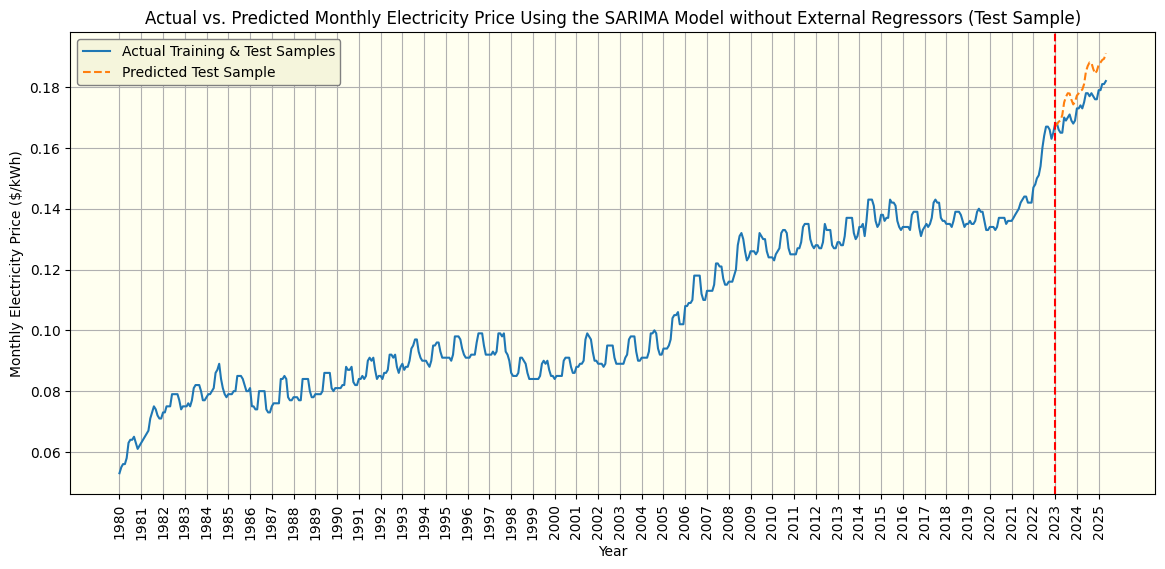

In [37]:
# Predicting the out-sample data using the fitted SARIMA model
predicted_test_sarima_no_regr = fit_no_reg.predict(start=len(df_train), end=len(df)-1)

print(f"First 5 Rows of Predicted Values for the Test Data Set:")
print(predicted_test_sarima_no_regr.head())
print()
print(f"Last 5 Rows of Predicted Values for the Test Data Set:")
print(predicted_test_sarima_no_regr.tail())
print()

# Plot for observed vs fitted values for the test sample:
plt.figure(figsize=(14, 6))
sns.lineplot(data= df, x= df['ds'], y=df['y'], label="Actual Training & Test Samples")
sns.lineplot(data= df_test, x= df_test['ds'], y= predicted_test_sarima_no_regr, linestyle="--", label="Predicted Test Sample")

# Add vertical line at 2023-01:
plt.axvline(x=pd.to_datetime('2023-01'), color='red', linestyle='--', linewidth=1.5)

plt.title("Actual vs. Predicted Monthly Electricity Price Using the SARIMA Model without External Regressors (Test Sample)")
plt.xlabel("Year")
plt.xticks(df['ds'][::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylabel("Monthly Electricity Price ($/kWh)")
plt.grid(True)
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('beige')
plt.gca().set_facecolor('ivory')
plt.show()


#### **Calculating RMSE and MAE of the SARIMA Model on the Test Sample**

In [38]:
# Calculating RMSE and MAE for test sample:
mse_test_SARIMA_Nreg = mean_squared_error(df_test['y'], predicted_test_sarima_no_regr)
rmse_test_SARIMA_Nreg = round(np.sqrt(mse_test_SARIMA_Nreg), 5)
mae_test_SARIMA_Nreg = round(mean_absolute_error(df_test['y'], predicted_test_sarima_no_regr), 5)

print(f"RMSE of the SARIMA Model without External Regressors on the Test Sample: {rmse_test_SARIMA_Nreg}")
print(f"MAE of the SARIMA Model without External Regressors on the Test Sample: {mae_test_SARIMA_Nreg}")


RMSE of the SARIMA Model without External Regressors on the Test Sample: 0.00715
MAE of the SARIMA Model without External Regressors on the Test Sample: 0.00667


### **Plotting the RMSE and MAE Metrics for the SARIMA Model with and without External Regressors**

                              RMSE      MAE
SARIMA with Regressors     0.01292  0.01192
SARIMA without Regressors  0.00715  0.00667 



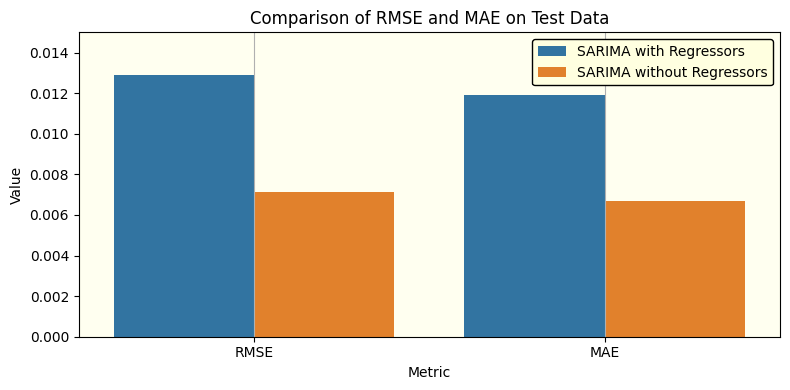

In [39]:
data = pd.DataFrame({'Metric': ['RMSE', 'MAE', 'RMSE', 'MAE'], 'Value': [rmse_test_SARIMA_Wreg, mae_test_SARIMA_Wreg, rmse_test_SARIMA_Nreg, mae_test_SARIMA_Nreg], 'Model': ['SARIMA with Regressors', 'SARIMA with Regressors', 'SARIMA without Regressors', 'SARIMA without Regressors']
})
print(pd.DataFrame({'RMSE': [rmse_test_SARIMA_Wreg, rmse_test_SARIMA_Nreg], 'MAE': [mae_test_SARIMA_Wreg, mae_test_SARIMA_Nreg]}, index= ['SARIMA with Regressors', 'SARIMA without Regressors']), '\n')

plt.figure(figsize=(8, 4))
sns.barplot(data=data, x='Metric', y='Value', hue='Model')

plt.title("Comparison of RMSE and MAE on Test Data")
plt.xlabel("Metric")
plt.ylim(0, 0.015)
plt.grid(axis='y')
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('ivory')
plt.tight_layout()
plt.grid()
plt.show()


#### **Inference from the Barplot of RMSE and MAE for the SARIMA Models**
The bar plot comparison of RMSE and MAE on the test dataset indicates that the **SARIMA model without external regressors** yielded better performance than the model that included monthly population as the only external predictor. Although this outcome may seem counterintuitive—given that external regressors are generally expected to enhance predictive performance—one possible explanation is that the inclusion of population, despite its statistical significance, may have introduced noise into the model or perhaps may not have captured variations in monthly electricity prices.

---
---

## **3. Fitting the Holt-Winters (Triple Exponential Smoothing) Model**
As previously mentioned, the Holt-Winters model does not support the inclusion of external regressors; therefore, none were incorporated into the model.

In [41]:
# Fitting The Holt-Winters model:
HW_model = ExponentialSmoothing(df_train['y'], trend='add',  seasonal='add', seasonal_periods= 12) # Additive seasonality ('seasonal="add"') was selected because it resulted in a lower AIC compared to multiplicative seasonality ('seasonal="mul"').
fit_HW = HW_model.fit()
print(fit_HW.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  516
Model:             ExponentialSmoothing   SSE                              0.001
Optimized:                         True   AIC                          -6990.699
Trend:                         Additive   BIC                          -6922.762
Seasonal:                      Additive   AICC                         -6989.323
Seasonal Periods:                    12   Date:                 Sun, 20 Jul 2025
Box-Cox:                          False   Time:                         17:51:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

First 5 Rows of Predicted Values for the Test Data Set:
516    0.166829
517    0.167669
518    0.168859
519    0.169698
520    0.171794
dtype: float64

Last 5 Rows of Predicted Values for the Test Data Set:
540    0.192765
541    0.193606
542    0.194796
543    0.195635
544    0.197730
dtype: float64



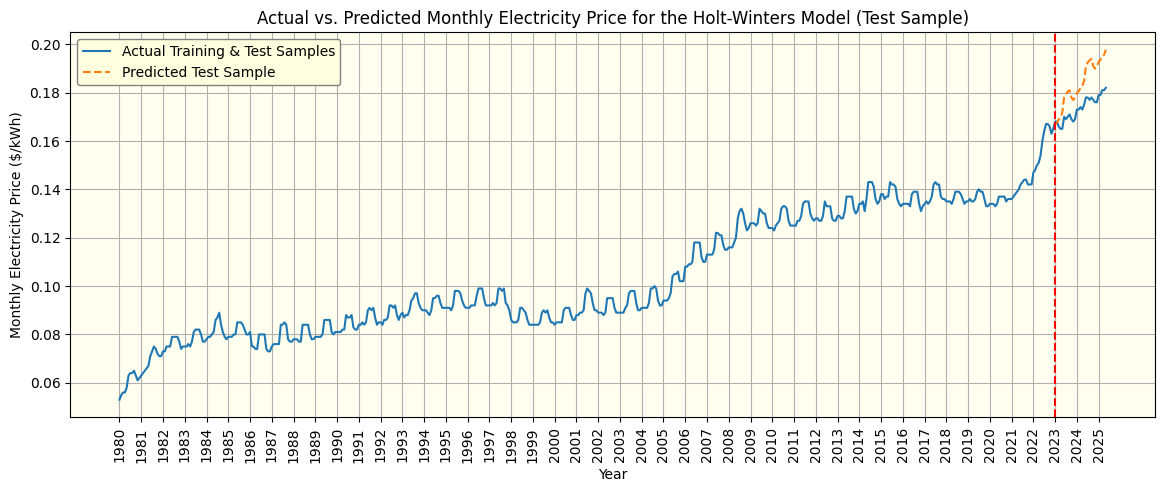

In [42]:
# Predicting the out-of-sample test data (number of observations for the test sample: 29):
predict_test_HW = fit_HW.forecast(29)
print(f"First 5 Rows of Predicted Values for the Test Data Set:")
print(predict_test_HW.head())
print()
print(f"Last 5 Rows of Predicted Values for the Test Data Set:")
print(predict_test_HW.tail())
print()

# Plotting the observed vs fitted values for the test sample:
plt.figure(figsize=(14, 5))
sns.lineplot(data= df, x= df['ds'], y=df['y'],label="Actual Training & Test Samples")
sns.lineplot(data= df_test, x= df_test['ds'], y= predict_test_HW, linestyle="--", label="Predicted Test Sample")
plt.axvline(x=pd.to_datetime('2023-01'), color='red', linestyle='--', linewidth=1.5)

plt.title("Actual vs. Predicted Monthly Electricity Price for the Holt-Winters Model (Test Sample)")
plt.xlabel("Year")
plt.xticks(df['ds'][::12], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylabel("Monthly Electricity Price ($/kWh)")
plt.grid(True)
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('ivory')
plt.show()


#### **Calculating RMSE and MAE of the Holt-Winters Model on the Test Sample**

In [43]:
# Calculating RMSE and MAE for test sample:
mse_test_HW = mean_squared_error(df_test['y'], predict_test_HW)
rmse_test_HW = round(np.sqrt(mse_test_HW), 5)
mae_test_HW = round(mean_absolute_error(df_test['y'], predict_test_HW), 5)

print(f"RMSE of the Holt-Winters on the Test Sample: {rmse_test_HW}")
print(f"MAE of the Holt-Winters on the Test Sample: {mae_test_HW}")


RMSE of the Holt-Winters on the Test Sample: 0.01117
MAE of the Holt-Winters on the Test Sample: 0.01029


---
---

## **COMPARISON OF RMSE AND MAE ACROSS TIME SERIES MODELS ON TEST DATA**

Metric                                   MAE     RMSE
Model                                                
Facebook Prophet with Regressors     0.00523  0.00621
Facebook Prophet without Regressors  0.01500  0.01530
Holt-Winters                         0.01029  0.01117
SARIMA with Regressors               0.01192  0.01292
SARIMA without Regressors            0.00667  0.00715 



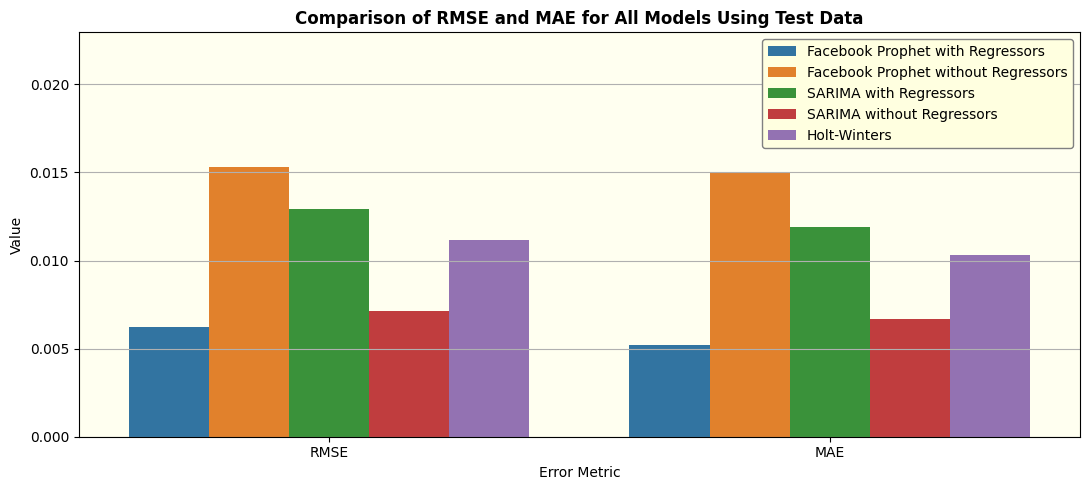

In [44]:
data_all = pd.DataFrame({
    'Model': [
        'Facebook Prophet with Regressors', 'Facebook Prophet with Regressors',
        'Facebook Prophet without Regressors', 'Facebook Prophet without Regressors',
        'SARIMA with Regressors', 'SARIMA with Regressors',
        'SARIMA without Regressors', 'SARIMA without Regressors',
        'Holt-Winters', 'Holt-Winters'
    ],
    'Metric': ['RMSE', 'MAE'] * 5,
    'Value': [
        rmse_test_FB_Wreg, mae_test_FB_Wreg,
        rmse_test_FB_Nreg, mae_test_FB_Nreg,
        rmse_test_SARIMA_Wreg, mae_test_SARIMA_Wreg,
        rmse_test_SARIMA_Nreg, mae_test_SARIMA_Nreg,
        rmse_test_HW, mae_test_HW
    ]
})

# Table of RMSE and MAE values across the time series models
print(data_all.pivot(index='Model', columns='Metric', values='Value'), '\n')

# Plotting the RMSE and MAE values for different models:
plt.figure(figsize=(11, 5))
sns.barplot(data=data_all, x='Metric', y='Value', hue='Model')
plt.title("Comparison of RMSE and MAE for All Models Using Test Data", fontweight='bold')
plt.xlabel("Error Metric")
plt.ylabel("Value")
plt.ylim(0, max(data_all['Value']) * 1.5)
plt.grid(axis='y')
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('ivory')

plt.tight_layout()
plt.show()


The bar plot of RMSE and MAE values on the test dataset for the time series models developed in this project indicates that the **Facebook Prophet model with external regressors** achieved the best predictive performance among the candidate models, followed by the SARIMA model without external regressors.



---
---

## **Static and Interactive Plots of Actual vs. Predicted Electricity Prices**
The static and interactive plots below illustrate the actual (observed) and predicted monthly electricity prices over the test period (**January 2023 – May 2025**), generated using all the five time series forecasting models developed in this project.

As shown in the plots, the Facebook Prophet model with external regressors produced predictions that aligned more closely with the actual values compared to the other models. This outperformance can be attributed to the ability of the Facebook Prophet to capture nonlinear trends and multiple seasonalities (e.g., yearly or monthly patterns) while incorporating significant external predictors. Additionally, Facebook Prophet model handles structural changes in time series data through tuning its changepoint parameters, such as changepoint prior scale and number of changepoints. These allow the model to account for sudden jumps or drops in trend, which may be caused by external unobserved factors, contributing to more accurate predictions and future forecasts in real-world settings.

### **(A) Static Plot of Actual vs. Predicted Electricity Prices**

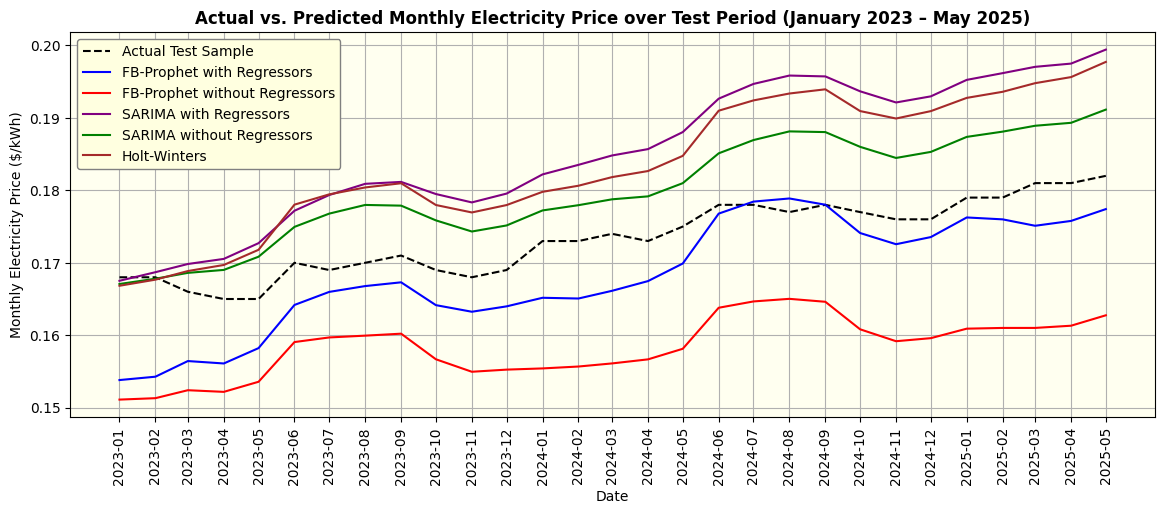

In [49]:
plt.figure(figsize=(14, 5))
sns.lineplot(data= df, x= df_test['ds'], y=df_test['y'],label="Actual Test Sample", linestyle="--", color= 'black')
sns.lineplot(data= df_test, x= df_test['ds'], y= predicted_test_FB_Wreg,  label='FB-Prophet with Regressors', color= 'blue')
sns.lineplot(data= df_test, x= df_test['ds'], y= predicted_test_FB_Nreg, label='FB-Prophet without Regressors', color= 'red')
sns.lineplot(data= df_test, x= df_test['ds'], y= predicted_test_sarima_wregr, label='SARIMA with Regressors', color= 'purple')
sns.lineplot(data= df_test, x= df_test['ds'], y= predicted_test_sarima_no_regr, label='SARIMA without Regressors', color= 'green')
sns.lineplot(data= df_test, x= df_test['ds'], y= predict_test_HW, label="Holt-Winters", color='brown')

plt.title("Actual vs. Predicted Monthly Electricity Price over Test Period (January 2023 – May 2025)", fontweight='bold')
plt.xlabel("Date")
plt.xticks(df_test['ds'][::1], rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.ylabel("Monthly Electricity Price ($/kWh)")
plt.grid(True)
legend = plt.legend(framealpha=1)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_facecolor('lightyellow')
plt.gca().set_facecolor('ivory')
plt.show()


### **(B) Interactive Plot of Actual vs. Predicted Electricity Prices**


In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test['ds'], y= df_test['y'], mode='lines', name='Actual Test Values', line=dict(color='black', dash='dash')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=predicted_test_FB_Wreg, mode='lines', name='FB-P with Regressors', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=predicted_test_FB_Nreg, mode='lines', name='FB-P without Regressors', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=predicted_test_sarima_wregr, mode='lines', name='SARIMA with Regressors', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=predicted_test_sarima_no_regr, mode='lines', name='SARIMA without Regressors', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=predict_test_HW, mode='lines', name='Holt-Winters', line=dict(color='brown')))

# Set the layout
fig.update_layout(
    title='Actual vs. Predicted Monthly Electricity Price over Test Period (January 2023 – May 2025)',
    xaxis_title='Date',
    yaxis_title='Monthly Electricity Price ($/kWh)',
    title_font=dict(size=18),
    font=dict(family='Arial', size=14),
    hovermode='x unified',
    width=1300,
    height=600
)

fig.show()


## **SUGGESTIONS FOR FUTURE WORK**
As demonstrated in this project, the **Facebook Prophet model with external predictors** acheived the best performance on the unseen test dataset. However, given that the Facebook Prophet model is a relatively new time series model, its applicability in time series forecasting has not been as extensively validated as traditional techniques, like SARIMA or Holt-Winters.
**For future research**, it is recommended to further explore the application of the Prophet model in modeling and forecasting other types of time-varying phenomena, particularly in domains where external regressors may play a significant role.

Another promising avenue for future work involves applying supervised machine learning techniques, such as **XGBoost**, in modeling time series data, especially when dealing with multiple external features that may influence the target variable.
